In [23]:
#!pip install np_utils

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [25]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [26]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

# free some space
#del train

In [27]:
# visualize number of digits classes
#plt.figure(figsize=(15,7))
#g = sns.countplot(Y_train, palette="icefire")
#plt.title("Number of digit classes")
Y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

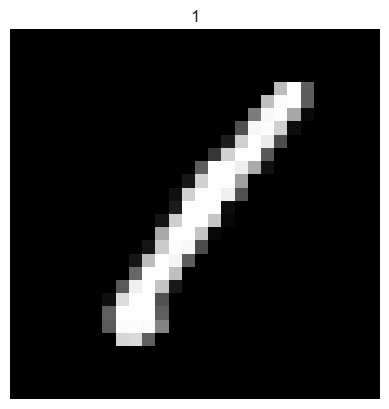

In [28]:
type(X_train)
#pd.DataFrame.as_matrix has been deprecated since version 0.23.0
#use pd.DataFrame.to_numpy() instead
img = X_train.iloc[0].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

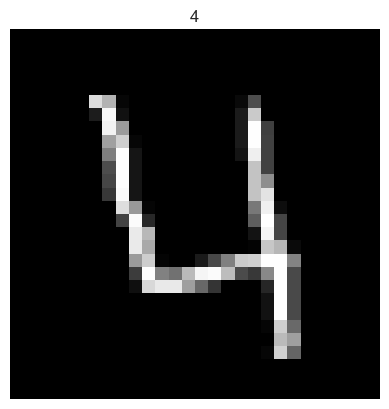

In [29]:
# plot some samples
img = X_train.iloc[3].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[3,0])
plt.axis("off")
plt.show()

In [30]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [31]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [32]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [33]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [34]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [35]:
# Set the random seed
random_seed = 2

In [36]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [37]:
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

In [39]:
# Define the optimizer
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) this style is deprecated since 2.3
import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.0)
optimizer = tf.keras.optimizers.RMSprop(rho=0.9, epsilon=1e-08, learning_rate=lr_schedule)


In [40]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [41]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [42]:
epochs = 5 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [43]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [45]:
# Fit the model
#history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
#                              epochs = epochs, validation_data = (X_val,Y_val),
#                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
#                              , callbacks=[learning_rate_reduction])

'''history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
'''

history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))


Epoch 1/5
1182/1182 [==============================] - 68s 57ms/step - loss: 2195.1287 - accuracy: 0.1168 - val_loss: 2037.1979 - val_accuracy: 0.1157
Epoch 2/5
1182/1182 [==============================] - 69s 58ms/step - loss: 2195.8704 - accuracy: 0.1159 - val_loss: 2037.1979 - val_accuracy: 0.1157
Epoch 3/5
1182/1182 [==============================] - 67s 57ms/step - loss: 2193.2595 - accuracy: 0.1175 - val_loss: 2037.1979 - val_accuracy: 0.1157
Epoch 4/5
1182/1182 [==============================] - 71s 60ms/step - loss: 2201.0103 - accuracy: 0.1163 - val_loss: 2037.1979 - val_accuracy: 0.1157
Epoch 5/5
1182/1182 [==============================] - 69s 58ms/step - loss: 2198.9077 - accuracy: 0.1156 - val_loss: 2037.1979 - val_accuracy: 0.1157


132/132 [==============================] - 1s 4ms/step - loss: 35.5093 - accuracy: 0.1212


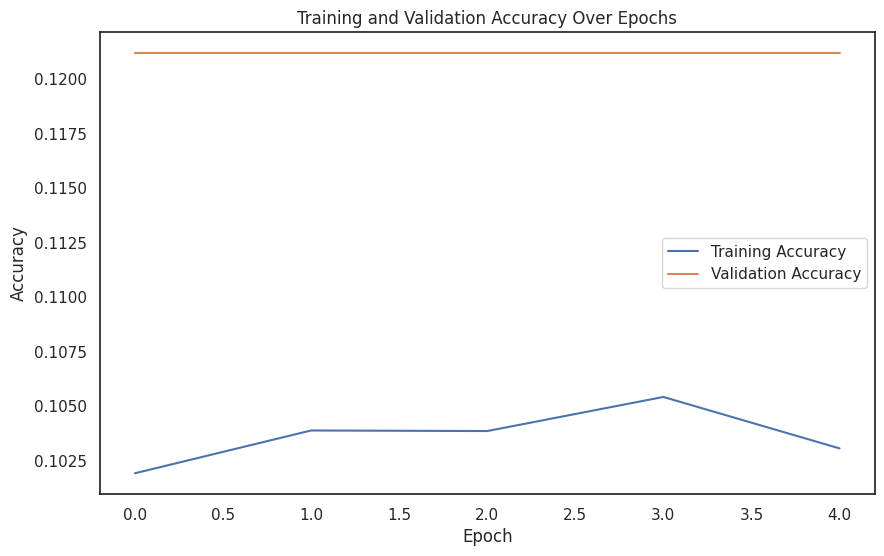

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, Y_train)
val_loss, val_accuracy = model.evaluate(X_val, Y_val)

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()


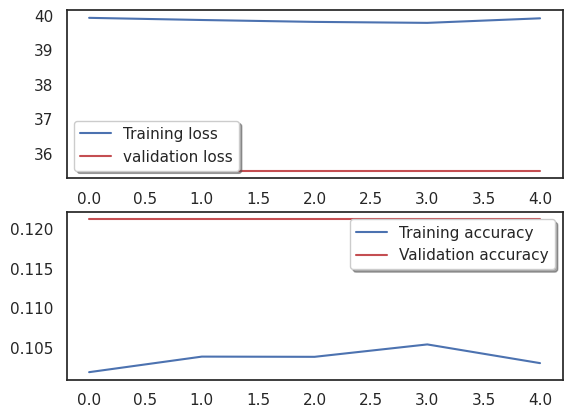

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)